# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms, KNN, naïve Bayesian and logistic regression, and SVM.

In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

## 1. Preprocessing

In [1]:
%matplotlib inline
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot.metrics as skplt
import math
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import datasets

import gensim
import string
import pickle
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from collections import Counter
from sklearn.calibration import CalibratedClassifierCV

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

1.1 Load the data

In [3]:
con = sqlite3.connect('database.sqlite')

messages = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

print(messages.shape)
messages

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


1.2 Remove duplicates and null value

In [4]:
messages["Time"] = messages["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
sortedData = messages.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)
# drop row that include null value in text column and score column
messages = final[['Time','Text','Score']].dropna()
final.shape

(364173, 10)

1.3 Distribution of original data

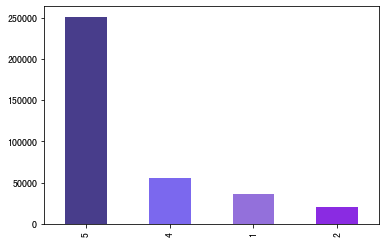

In [5]:
color_bar = ['darkslateblue','mediumslateblue','mediumpurple','blueviolet','darkorchid','darkviolet','mediumorchid',
             'm','fuchsia','magenta','orchid','deeppink','hotpink','pink','lightpink']
ax=messages.Score.value_counts().plot(kind='bar',color=color_bar)
fig = ax.get_figure()
fig.savefig("score_origin.png");

1.4 Transform origianl score to negative and positive

As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

,Time,Text,Score
138706,1999-10-08 08:00:00,this witty little book makes my son laugh at l...,positive
138688,2007-11-11 08:00:00,"I grew up reading these Sendak books, and watc...",positive
138689,2007-10-04 08:00:00,This is a fun way for children to learn their ...,positive
138690,2004-02-06 08:00:00,This is a great little book to read aloud- it ...,positive
138691,2002-04-10 08:00:00,This is a book of poetry about the months of t...,positive


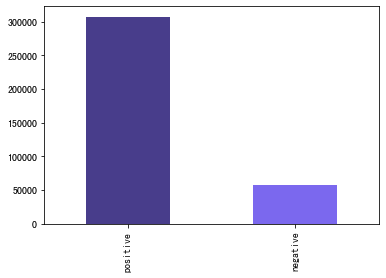

In [6]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

score = messages['Score']
messages['Score'] = score.map(partition)
text = messages['Text']

# split and see the rating distribution
ax=messages['Score'].value_counts().plot(kind='bar',color=color_bar)
fig = ax.get_figure()
fig.savefig("score_pos_neg.png")
messages.head()

1.5 Split the data into a training set and a test set

The data will be split into an training set and a test set with a test set ratio of 0.2

In [7]:
score = messages['Score']
text = messages['Text']

x_train, x_test, y_train, y_test = train_test_split(text, score, test_size=0.2, random_state=50)

## 2. Data Cleaning

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :
- Stemming
- Lowering
- Pruning (numbers and punctuation)

In [8]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

In [9]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [10]:
def stem_lower_pruning(x_train,x_test):
    intab = string.punctuation
    outtab = "                                "
    trantab = str.maketrans(intab, outtab)

    #--- Training set
    corpus = []
    for text in x_train:
        text = text.lower()
        text = text.translate(trantab)
        text=tokenize(text)
        corpus.append(text)

    #--- Test set
    test_set = []
    for text in x_test:
        text = text.lower()
        text = text.translate(trantab)
        text=tokenize(text)
        test_set.append(text)
    
    df = pd.DataFrame({'Before': x_train, 'After': corpus})
    print(df.head(10))

    prediction = dict()
    return corpus, test_set

In [11]:
stemmer = PorterStemmer()
x_train, x_test = stem_lower_pruning(x_train,x_test)

                                                   Before  \
176131  I specifically ordered these from Amazon rathe...   
116405  Very cute card came with the seeds, but wow th...   
361830  The bars are very good, and priced very compet...   
315078  I purchased this cracker because it was among ...   
203895  Very nice combination of nuts and fruits.  I a...   
283099  My Amazon order for "Country Choice Organic Ir...   
240524  No almond slivers, contain corn syrup, nice ta...   
163371  I've never reviewed a food before. So this'll ...   
9020    I got these for my boyfriend for Christmas. Th...   
117229  Both of my dogs (chihuahua & corgi) love these...   

                                                    After  
176131  i specif order these from amazon rather than b...  
116405  veri cute card came with the seed but wow ther...  
361830  the bar are veri good and price veri competit ...  
315078  i purchas thi cracker becaus it wa among the m...  
203895  veri nice combin of 

## 3. Feature Extraction

### 3.1 Uni-Gram

In [12]:
unigram = CountVectorizer()
x_uni = unigram.fit_transform(x_train)
x_uni_test = unigram.transform(x_test)

### 3.2 Bi-Gram

In [13]:
bigram = CountVectorizer(ngram_range=(2,2))
x_bi = unigram.fit_transform(x_train) 
x_bi_test = unigram.transform(x_test)

### 3.3 TF-IDF

In [14]:
tf_idf_vect = TfidfVectorizer()
x_tfidf = tf_idf_vect.fit_transform(x_train)
x_tfidf_test = tf_idf_vect.transform(x_test)

### 3.4 Uni-Gram and TF-IDF

In [15]:
X_train_counts = unigram.fit_transform(x_train)        
X_new_counts = unigram.transform(x_test)
tfidf_transformer = TfidfTransformer()
x_uni_tfidf = tfidf_transformer.fit_transform(X_train_counts)
x_uni_tfidf_test = tfidf_transformer.transform(X_new_counts)

## 4. Fitting the models

### 4.1 Result Plot and Analysis

In [16]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

In [17]:
def result_plot(prediction):
    cmp = 0
    colors = ['b', 'g', 'y', 'm', 'k']
    for model, predicted in prediction.items():
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp += 1

    plt.title('Classifiers comparaison with ROC')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 4.2 Multinomial Naïve Bayes model

In [94]:
prediction_mnb = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [95]:
mnb_uni_model = MultinomialNB().fit(x_uni, y_train)
prediction_mnb['Multinomial-NB-uni'] = mnb_uni_model.predict(x_uni_test)

In [96]:
mnb_bi_model = MultinomialNB().fit(x_bi, y_train)
prediction_mnb['Multinomial-NB-bi'] = mnb_bi_model.predict(x_bi_test)

In [97]:
mnb_tfidf_model = MultinomialNB().fit(x_tfidf, y_train)
prediction_mnb['Multinomial-NB-tfidf'] = mnb_tfidf_model.predict(x_tfidf_test)

In [100]:
mnb_uni_tfidf_model = MultinomialNB().fit(x_uni_tfidf, y_train)
prediction_mnb['Multinomial-NB-uni-tfidf'] = mnb_uni_tfidf_model.predict(x_uni_tfidf_test)

Result Analysis

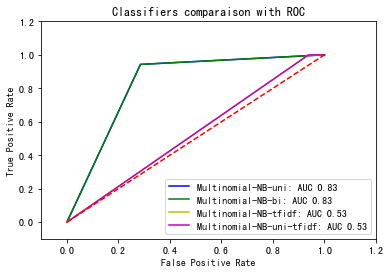

In [101]:
result_plot(prediction_mnb)

### 4.3 Bernoulli Naïve Bayes model

In [102]:
prediction_bnb = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [103]:
bnb_uni_model = BernoulliNB().fit(x_uni, y_train)
prediction_bnb['Bernoulli-NB-uni'] = bnb_uni_model.predict(x_uni_test)

In [104]:
bnb_bi_model = BernoulliNB().fit(x_bi, y_train)
prediction_bnb['Bernoulli-NB-bi'] = bnb_bi_model.predict(x_bi_test)

In [105]:
bnb_tfidf_model = BernoulliNB().fit(x_tfidf, y_train)
prediction_bnb['Bernoulli-NB-tfidf'] = bnb_tfidf_model.predict(x_tfidf_test)

In [107]:
bnb_uni_tfidf_model = BernoulliNB().fit(x_uni_tfidf, y_train)
prediction_bnb['Bernoulli-NB-uni_tfidf'] = bnb_uni_tfidf_model.predict(x_uni_tfidf_test)

Result Analysis

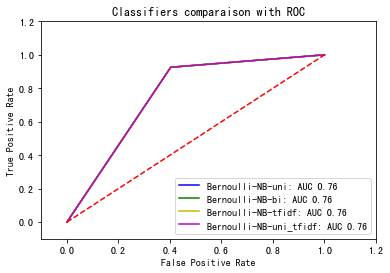

In [109]:
result_plot(prediction_bnb)

### 4.4 Logistic regression model

In [117]:
prediction_lr = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [118]:
lr_uni_model = LogisticRegression(C=1e5,n_jobs=-1)
lr_uni_model.fit(x_uni, y_train)
prediction_lr['Logistic_lr_uni'] = lr_uni_model.predict(x_uni_test)

In [119]:
lr_bi_model = LogisticRegression(C=1e5,n_jobs=-1).fit(x_bi, y_train)
prediction_lr['Logistic_lr_bi'] = lr_bi_model.predict(x_bi_test)

In [120]:
lr_tfidf_model = LogisticRegression(C=1e5,n_jobs=-1).fit(x_tfidf, y_train)
prediction_lr['Logistic_lr_tfidf'] = lr_tfidf_model.predict(x_tfidf_test)

In [121]:
lr_uni_tfidf_model = LogisticRegression(C=1e5,n_jobs=-1).fit(x_uni_tfidf, y_train)
prediction_lr['Logistic_lr_uni_tfidf'] = lr_uni_tfidf_model.predict(x_uni_tfidf_test)

Result Analysis

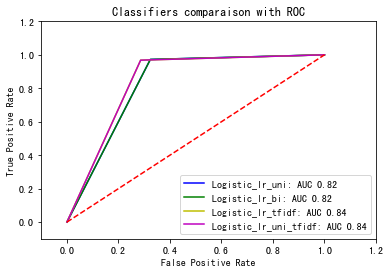

In [122]:
result_plot(prediction_lr)

### 4.5 KNN model

In [123]:
prediction_knn = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [125]:
knn_uni_model = KNeighborsClassifier(n_jobs=-1).fit(x_uni, y_train)
prediction_knn['knn_uni'] = knn_uni_model.predict(x_uni_test)

In [126]:
knn_bi_model = KNeighborsClassifier(n_jobs=-1).fit(x_bi, y_train)
prediction_knn['knn_bi'] = knn_bi_model.predict(x_bi_test)

In [127]:
knn_tfidf_model = KNeighborsClassifier(n_jobs=-1).fit(x_tfidf, y_train)
prediction_knn['knn_tfidf'] = knn_tfidf_model.predict(x_tfidf_test)

In [128]:
knn_uni_tfidf_model = KNeighborsClassifier(n_jobs=-1).fit(x_uni_tfidf, y_train)
prediction_knn['knn_uni_tfidf'] = knn_uni_tfidf_model.predict(x_uni_tfidf_test)

Result Analysis

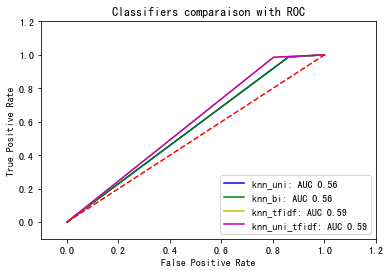

In [129]:
result_plot(prediction_knn)

### 4.6 SVM model

In [134]:
prediction_svm = dict()

In [135]:
svm_uni_model = SGDClassifier(n_jobs = -1).fit(x_uni, y_train)
prediction_svm['svm_uni'] = svm_uni_model.predict(x_uni_test)

In [136]:
svm_bi_model = SGDClassifier(n_jobs = -1).fit(x_bi, y_train)
prediction_svm['svm_bi'] = svm_bi_model.predict(x_bi_test)

In [137]:
svm_tfidf_model = SGDClassifier(n_jobs = -1).fit(x_tfidf, y_train)
prediction_svm['svm_tfidf'] = svm_tfidf_model.predict(x_tfidf_test)

In [138]:
svm_uni_tfidf_model = SGDClassifier(n_jobs = -1).fit(x_uni_tfidf, y_train)
prediction_svm['svm_uni_tfidf'] = svm_uni_tfidf_model.predict(x_uni_tfidf_test)

Result Analysis

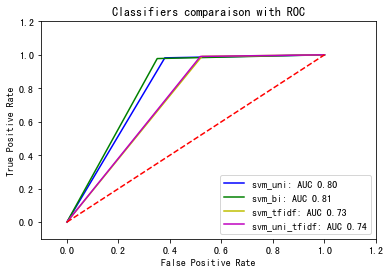

In [139]:
result_plot(prediction_svm)

### 4.7 Random Forest model

In [18]:
prediction_rf = dict()

In [19]:
rf_uni_model = RandomForestClassifier(n_jobs = -1).fit(x_uni, y_train)
prediction_rf['rf_uni'] = rf_uni_model.predict(x_uni_test)

In [20]:
rf_bi_model = RandomForestClassifier(n_jobs = -1).fit(x_bi, y_train)
prediction_rf['rf_bi'] = rf_bi_model.predict(x_bi_test)

In [21]:
rf_tfidf_model = RandomForestClassifier(n_jobs = -1).fit(x_tfidf, y_train)
prediction_rf['rf_tfidf'] = rf_tfidf_model.predict(x_tfidf_test)

In [22]:
rf_uni_tfidf_model = RandomForestClassifier(n_jobs = -1).fit(x_uni_tfidf, y_train)
prediction_rf['rf_uni_tfidf'] = rf_uni_tfidf_model.predict(x_uni_tfidf_test)

Result Analysis

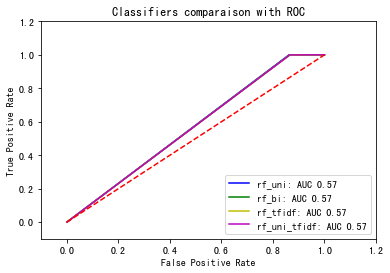

In [23]:
result_plot(prediction_rf)

### 4.8 GBC model

In [24]:
prediction_gbc = dict()

In [26]:
gbc_uni_model = GradientBoostingClassifier().fit(x_uni, y_train)
prediction_gbc['gbc_uni'] = gbc_uni_model.predict(x_uni_test)

In [27]:
gbc_bi_model = GradientBoostingClassifier().fit(x_bi, y_train)
prediction_gbc['gbc_bi'] = gbc_bi_model.predict(x_bi_test)

In [28]:
gbc_tfidf_model = GradientBoostingClassifier().fit(x_tfidf, y_train)
prediction_gbc['gbc_tfidf'] = gbc_tfidf_model.predict(x_tfidf_test)

Result Analysis

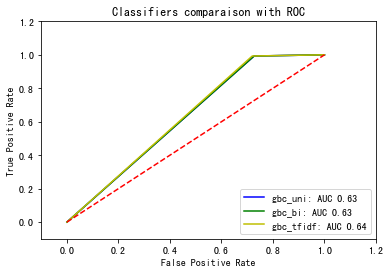

In [30]:
result_plot(prediction_gbc)